In [3]:
#import the libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.preprocessing import StandardScaler 

In [16]:
#load and parse data
df = pd.read_csv("TCS.csv")


# DATA PRE-PROCESSING

In [6]:
df['Date']=pd.to_datetime(df['Date']); df=df.sort_values('Date')

In [7]:
#setting the index 
df = df.set_index('Date')

In [8]:
#drop constants  because the never vary 
df.drop(columns=['Symbol','Series'], inplace=True)

In [9]:
#fix trades gaps 
df['Trades']=df['Trades'].interpolate()

In [10]:
#create business-day series 
close_ts=df['Close'].asfreq('B').interpolate()

In [14]:
#saving the clean data 
df


,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,
2004-08-25,850.00,1198.70,1198.70,979.00,985.00,987.95,1008.32,17116372,1.725876e+15,NaN,5206360,0.3042
2004-08-26,987.95,992.00,997.00,975.30,976.85,979.00,985.65,5055400,4.982865e+14,NaN,1294899,0.2561
2004-08-27,979.00,982.40,982.40,958.55,961.20,962.65,969.94,3830750,3.715586e+14,NaN,976527,0.2549
2004-08-30,962.65,969.90,990.00,965.00,986.40,986.75,982.65,3058151,3.005106e+14,NaN,701664,0.2294
2004-08-31,986.75,986.50,990.00,976.00,987.80,988.10,982.18,2649332,2.602133e+14,NaN,695234,0.2624
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-26,3109.50,3102.05,3153.00,3088.05,3100.05,3100.80,3122.35,2490260,7.775465e+14,87012.0,1345353,0.5402
2021-04-27,3100.80,3106.00,3136.10,3103.00,3132.75,3132.00,3122.18,1471417,4.594036e+14,97077.0,849767,0.5775
2021-04-28,3132.00,3149.95,3151.00,3112.00,3123.00,3124.10,3125.72,1639037,5.123176e+14,76017.0,847762,0.5172


In [17]:
df.shape

(4139, 15)

In [19]:
df.head(10)

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2004-08-25,TCS,EQ,850.00,1198.7,1198.7,979.00,985.00,987.95,1008.32,17116372,1.725876e+15,NaN,5206360,0.3042
1,2004-08-26,TCS,EQ,987.95,992.0,997.0,975.30,976.85,979.00,985.65,5055400,4.982865e+14,NaN,1294899,0.2561
2,2004-08-27,TCS,EQ,979.00,982.4,982.4,958.55,961.20,962.65,969.94,3830750,3.715586e+14,NaN,976527,0.2549
3,2004-08-30,TCS,EQ,962.65,969.9,990.0,965.00,986.40,986.75,982.65,3058151,3.005106e+14,NaN,701664,0.2294
4,2004-08-31,TCS,EQ,986.75,986.5,990.0,976.00,987.80,988.10,982.18,2649332,2.602133e+14,NaN,695234,0.2624
5,2004-09-01,TCS,EQ,988.10,990.0,995.0,983.60,986.00,987.90,989.68,2491943,2.466236e+14,NaN,790586,0.3173
6,2004-09-02,TCS,EQ,987.90,989.9,1004.6,986.00,994.00,993.65,996.96,2669544,2.661426e+14,NaN,501792,0.1880
7,2004-09-03,TCS,EQ,993.65,1006.0,1100.0,990.35,998.70,997.85,996.91,1233732,1.229917e+14,NaN,235508,0.1909
8,2004-09-06,TCS,EQ,997.85,1039.9,1039.9,992.90,996.80,994.85,998.87,1129834,1.128554e+14,NaN,430184,0.3807
9,2004-09-07,TCS,EQ,994.85,1035.0,1035.0,995.00,995.00,995.60,997.34,721529,7.196109e+13,NaN,198212,0.2747


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4139 entries, 0 to 4138
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                4139 non-null   object 
 1   Symbol              4139 non-null   object 
 2   Series              4139 non-null   object 
 3   Prev Close          4139 non-null   float64
 4   Open                4139 non-null   float64
 5   High                4139 non-null   float64
 6   Low                 4139 non-null   float64
 7   Last                4139 non-null   float64
 8   Close               4139 non-null   float64
 9   VWAP                4139 non-null   float64
 10  Volume              4139 non-null   int64  
 11  Turnover            4139 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4139 non-null   int64  
 14  %Deliverble         4139 non-null   float64
dtypes: float64(10), int64(2), object(3)
memory usage: 485.2

In [22]:
#Use ADF Test to check stationarity
from statsmodels.tsa.stattools import adfuller

result = adfuller(close_ts.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] < 0.05:
    print("✅ The series is stationary (good for ARIMA).")
else:
    print("❌ The series is non-stationary. Differencing needed.")



ADF Statistic: -0.9518501645148101
p-value: 0.7704185095871026
❌ The series is non-stationary. Differencing needed.


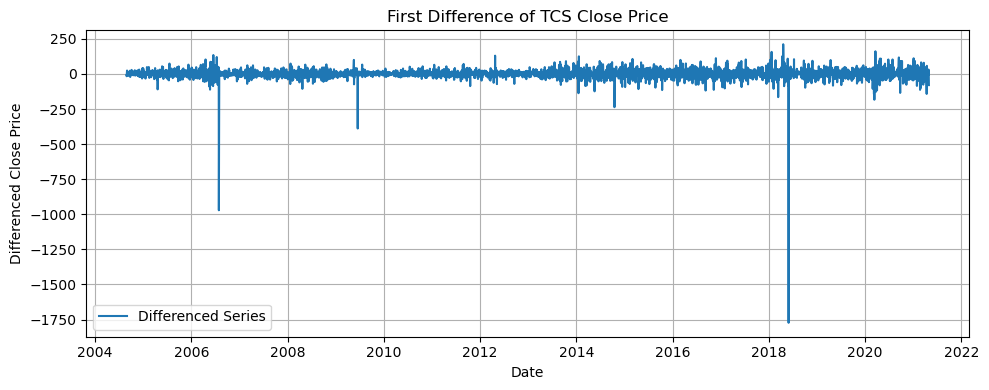

In [23]:
#As series is non-stationary ,perform differencing (to make it stationary)
close_diff = close_ts.diff().dropna()

plt.figure(figsize=(10, 4))
plt.plot(close_diff, label="Differenced Series")
plt.title("First Difference of TCS Close Price")
plt.xlabel("Date")
plt.ylabel("Differenced Close Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


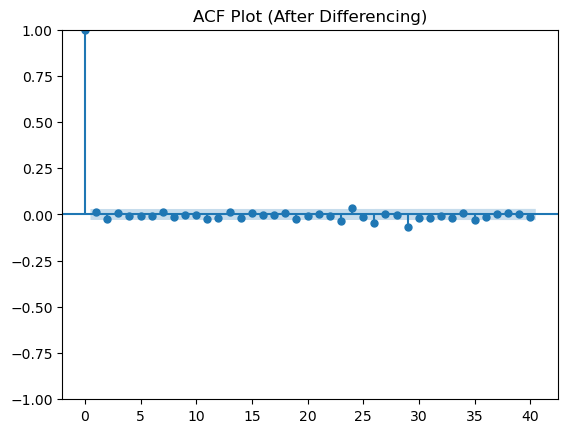

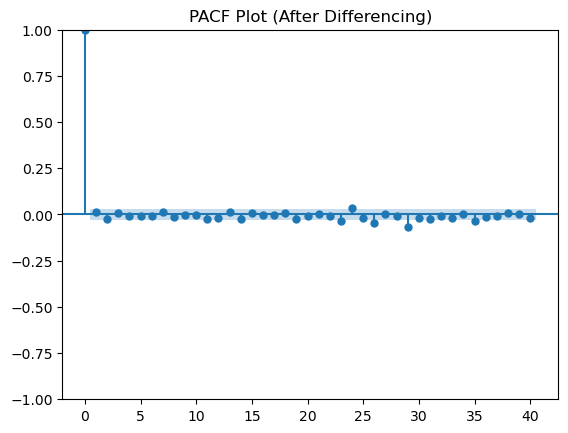

In [26]:
#perform ACF and PACF plots (for seasonality and arima orders)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(close_diff, lags=40)
plt.title("ACF Plot (After Differencing)")
plt.show()

plot_pacf(close_diff, lags=40)
plt.title("PACF Plot (After Differencing)")
plt.show()


C:\Users\VANSHIKA\AppData\Local\Temp\ipykernel_23056\1267305510.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


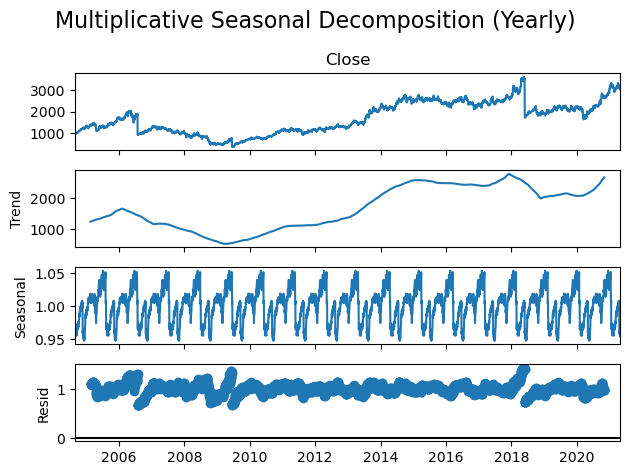

In [27]:
#seasonal decomposition (trend,residual and seasonality )
from statsmodels.tsa.seasonal import seasonal_decompose

# freq = 252 for yearly trend, 5 for weekly (business days)
result = seasonal_decompose(close_ts, model='multiplicative', period=252)

result.plot()
plt.suptitle("Multiplicative Seasonal Decomposition (Yearly)", fontsize=16)
plt.tight_layout()
plt.show()


In [29]:
seasonal_strength = 1 - (result.resid.var() / (result.resid + result.seasonal).var())
print(f"Estimated seasonal strength: {seasonal_strength:.2f}")
#as a result it is close 1 which means string seasonality 


Estimated seasonal strength: 0.07


In [30]:
# SARIMA  (weekly seasonality example)
import statsmodels.api as sm
seasonal_order = (1, 0, 1, 5)      # 5=business-day week on NSE
sarima = sm.tsa.statespace.SARIMAX(
    close_ts, order=(2,1,2), seasonal_order=seasonal_order, enforce_stationarity=False
).fit()
print(sarima.summary())
sarima_forecast = sarima.get_forecast(steps=365).predicted_mean


                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                 4353
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 5)   Log Likelihood              -22456.734
Date:                             Thu, 05 Jun 2025   AIC                          44927.469
Time:                                     15:19:16   BIC                          44972.104
Sample:                                 08-25-2004   HQIC                         44943.225
                                      - 04-30-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1869      1.159     -0.161      0.872      -2.459       2.085
ar.L2          0.4345      

In [31]:
# ARIMAX  (price explained by Volume)

exog = df['Volume'].asfreq('B').interpolate()
train_y, test_y = close_ts[:-365], close_ts[-365:]
train_x, test_x = exog[:-365], exog[-365:]

arimax = sm.tsa.ARIMA(train_y, order=(3,1,2), exog=train_x).fit()
pred_y = arimax.forecast(steps=len(test_y), exog=test_x)


ValueError: zero-size array to reduction operation maximum which has no identity

In [32]:
#SARIMAX  (seasonality + exogenous Volume)

sarimax = sm.tsa.statespace.SARIMAX(
    train_y, order=(2,1,2), seasonal_order=(1,0,1,5), exog=train_x,
    enforce_stationarity=False
).fit()
sarimax_pred = sarimax.forecast(steps=len(test_y), exog=test_x)


ValueError: zero-size array to reduction operation maximum which has no identity

15:20:53 - cmdstanpy - INFO - Chain [1] start processing
15:20:55 - cmdstanpy - INFO - Chain [1] done processing


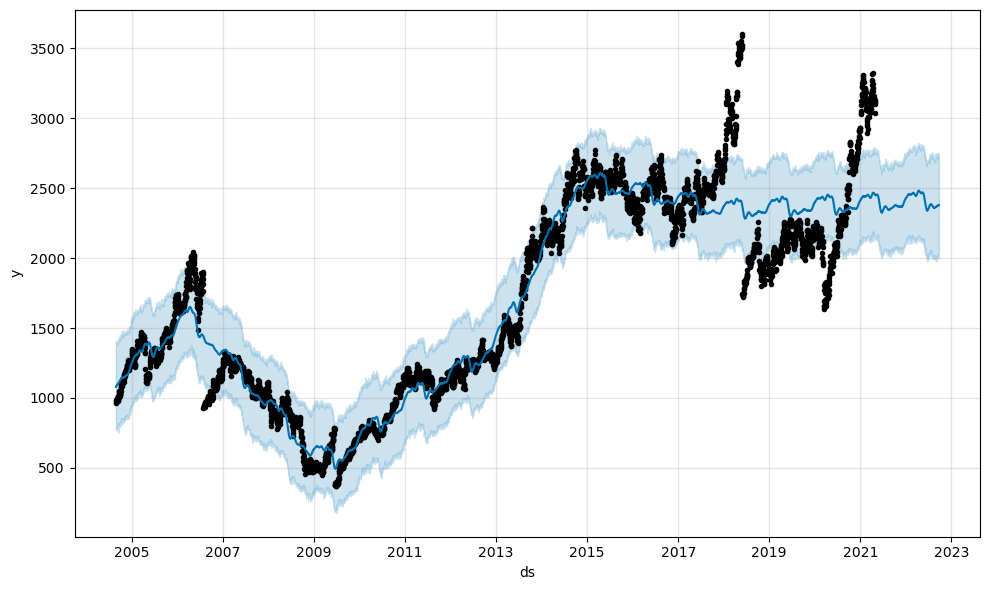

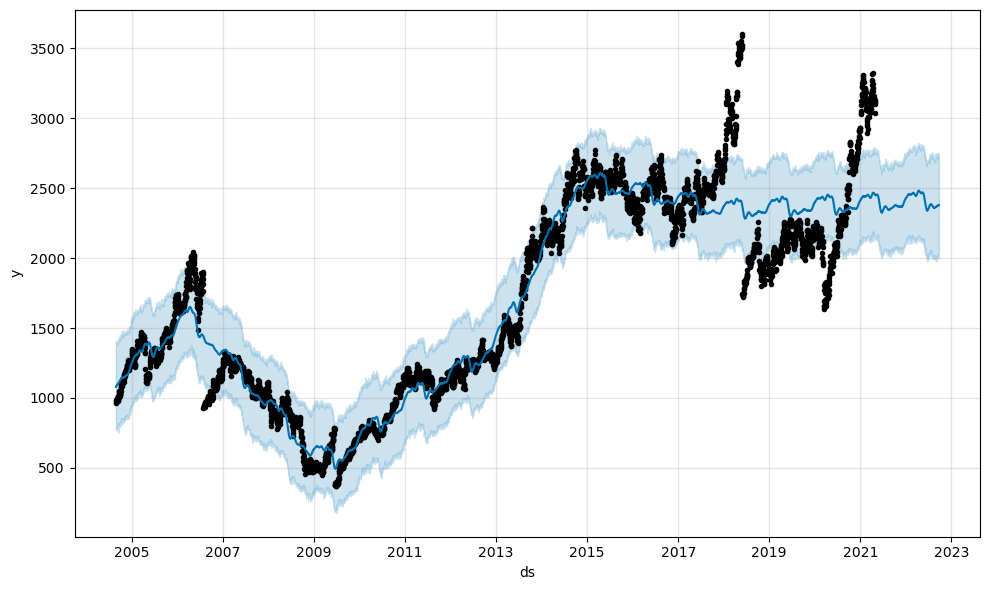

In [33]:
#  Prophet  (additive trend + seasonality)
#      NB: install once → pip install prophet
from prophet import Prophet
prophet_df = close_ts.reset_index().rename(columns={'Date':'ds','Close':'y'})
model = Prophet(daily_seasonality=False, weekly_seasonality=True,
                yearly_seasonality=True)
model.fit(prophet_df)

future = model.make_future_dataframe(periods=365, freq='B')
forecast = model.predict(future)
# forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()
model.plot(forecast)
